In [1]:
import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

from shapely.validation import make_valid


def fix_geom(in_feature):

    # avoid changing original geodf
    in_feature = in_feature.copy(deep=True)    
        
    # drop any missing geometries
    in_feature = in_feature[~(in_feature.is_empty)]
    
    # Repair broken geometries
    for index, row in in_feature.iterrows(): # Looping over all polygons
        if row['geometry'].is_valid:
            next
        else:
            fix = make_valid(row['geometry'])

            try:
                in_feature.loc[[index],'geometry'] =  fix # issue with Poly > Multipolygon
            except ValueError:
                in_feature.loc[[index],'geometry'] =  in_feature.loc[[index], 'geometry'].buffer(0)
    return in_feature

## Cargar geometrias

In [2]:
radios = gpd.read_file('./radios_IGN_2010_WGS84/')

In [3]:
# circuitos_ARG = gpd.read_file('./mapaelectoral/circuitos-CNE.geojson')
circuitos_ARG = gpd.read_file('./mapaelectoral/circuitos-CNE-TTGL.geojson')

## Interseccion espacial

In [4]:
circuitos_ARG.count()

circuito    5589
codprov     5563
coddepto    5563
seccion     1066
geometry    5559
dtype: int64

In [5]:
circuitos_ARG.nunique()

circuito    2058
codprov       24
coddepto     138
seccion        8
geometry    5550
dtype: int64

In [6]:
## Agregar codigos de provincia de INDEC
codprovs = pd.read_csv('./codprovs.csv', dtype = 'str')
codprovs['codprov'] = codprovs['codprov'].str.zfill(2)

circuitos_ARG = circuitos_ARG.merge(codprovs, how = 'left')

In [7]:

result_list = []

for indec_p in circuitos_ARG.indec_p.dropna().unique():
    cne_prov = circuitos_ARG.loc[circuitos_ARG.indec_p.fillna(indec_p) == indec_p]
    cne_prov = fix_geom(cne_prov.dropna(subset = 'geometry'))
    print(cne_prov.nomprov.unique())

    radios_prov = radios.loc[radios.PROV_ == indec_p]

#     ## Correccion de errores
#     radios_prov.loc[radios_prov.IN1 == '26028', 'DEPTO_'] = '063' # Esto es para adaptarse a un erorr en CNE
# #             (la CNE tiene unido camarones al dpto martires, por error)

    result_prov = []

#     for dpto in cne_prov.indec_d.unique():

#         if (cne_prov.indec_p.unique()[0] == '94') | (cne_prov.indec_p.unique()[0] == '22'):
# #                     print('chaco o tdf')
#             radios_dpto = radios_prov # En chaco y tdf, usar toda la provincia porque los codigos estan cambiados...
#         else:
#             radios_dpto = radios_prov.loc[radios_prov.DEPTO_ == dpto]

# #         circ_dpto = cne_prov.loc[cne_prov.indec_d == dpto]

# #     Check...
#     fig, axs = plt.subplots(1)
#     radios_prov.plot(ax = axs, alpha = .4)
#     cne_prov.plot(ax = axs, alpha = .4)
#     plt.show()


    ## Intersectar los radios en cuestion con los polis de IGS.
    inters = gpd.overlay(radios_prov, cne_prov[['circuito', 'codprov', 'coddepto', 'geometry']], how='intersection')
    
    
    if len(inters) != 0: # Si hay interseccion
        inters['area'] = inters.area

        year = '2010'
        # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
        radios_in_circu = inters.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]
                                        ).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True
                    )[['codprov', 'coddepto', 'PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
        
        # radios_in_circu['FRACC_2'] = radios_in_circu['COD_'+year].str[5:7]
        result_prov += [radios_in_circu]
    else:
#             print('sin interseccion en '+str(circ_dpto.departamen.unique()[0]))
        print('sin interseccion en '+str(cne_prov.nomprov.unique()[0]))

    result_prov = pd.concat(result_prov)



    ## Tomar radios que se asociaron a mas de 1 circuito. 
#     Esto pasa cuando se usa la provincia entera para intersecar (ie. chaco, tdf)
    duplicados = result_prov[result_prov.duplicated('COD_2010', keep = False)].sort_values('COD_2010')

    if len(duplicados) > 0:

        ## Volcarlos en 1 solo circuito.
        inters = gpd.overlay(gpd.GeoDataFrame(duplicados.drop('circuito', axis = 1).merge(radios)), 
                             gpd.GeoDataFrame(duplicados.merge(cne_prov))[['circuito', 'geometry']], how='intersection')

        if len(inters) != 0: # Si hay interseccion
            inters['area'] = inters.area

            year = '2010'
            # Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
            res_dup_prov = inters.groupby(['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year]
                                        ).apply(lambda x: x.nlargest(1, 'area')
                                               ).reset_index(drop = True)[['PROV_', 'DEPTO_', 'FRACC_', 'COD_'+year, 'IN1', 'circuito']]
        result_prov = pd.concat([result_prov[~result_prov.duplicated('COD_2010', keep = False)], res_dup_prov])

    result_list += [result_prov]

result = pd.concat(result_list).drop_duplicates()


['Ciudad Autónoma de Buenos Aires' nan]
['Catamarca' nan]
['Chaco' nan]
['Chubut' nan]
['Córdoba' nan]
['Corrientes' nan]
[nan 'Entre Ríos']
[nan 'Formosa']
[nan 'Jujuy']
[nan 'La Pampa']
[nan 'La Rioja']
[nan 'Mendoza']
[nan 'Misiones']
[nan 'Neuquén']
[nan 'Buenos Aires']
[nan 'Río Negro']
[nan 'Salta']
[nan 'San Luis']
[nan 'Santa Cruz']
[nan 'Santa Fe']
[nan 'Santiago del Estero']
[nan 'San Juan']
[nan 'Tierra del Fuego, Antártida e Islas del Atlántico Sur']
[nan 'Tucumán']


<AxesSubplot:>

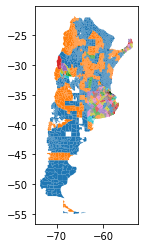

In [8]:
## Plot
gpd.GeoDataFrame(result.merge(radios)).plot('coddepto')


In [9]:
radios.nunique()

PROV_          24
DEPTO_        154
FRACC_         99
COD_2010    52401
IN1           525
geometry    52401
dtype: int64

In [10]:
result.nunique()

codprov        24
coddepto      138
PROV_          24
DEPTO_        154
FRACC_         99
COD_2010    52159
IN1           525
circuito     1974
dtype: int64

## Guardar resultados

In [11]:
result.to_csv('./info/radios_circuitos-TTGL.csv', index = False)

In [53]:
result.head()

,codprov,coddepto,PROV_,DEPTO_,FRACC_,COD_2010,IN1,circuito
0,01,001,02,001,01,020010101,0214007,00005
1,01,001,02,001,02,020010201,0214007,00005
2,01,001,02,001,02,020010202,0214007,00005
3,01,001,02,001,02,020010203,0214007,00005
4,01,001,02,001,02,020010204,0214007,00005


In [12]:
pd.options.display.max_rows = 99

In [13]:
## Cuando codprov y coddpto tienen mas de un IN1, elegir el que mas radios tiene en la interseccion.

test = result.groupby(['codprov', 'coddepto', 'IN1']).nunique().reset_index()
test['pct'] = test.groupby(['codprov', 'coddepto'])['COD_2010'].apply(lambda x: x/x.sum()).round(2)
test['test'] = abs(test['pct'] - .5)

# test.sort_values('test').head(20).sort_values('IN1')

In [50]:
solucion = test.groupby(['codprov', 'coddepto']).apply(lambda x: x.nlargest(1, 'COD_2010')).reset_index(drop = True)

solucion[['codprov', 'coddepto', 'IN1']].to_csv('./info/secciones_departamentos-TTGL.csv', index = False)

In [52]:
solucion[['codprov', 'coddepto', 'IN1']].head()

,codprov,coddepto,IN1
0,01,001,0214007
1,01,002,0214014
2,01,003,0214021
3,01,004,0214028
4,01,005,0214035


In [15]:
## Aplico buffer para evitar error con algunos poligonos (en Chubut)
radios_diss_IN1 = radios.copy()
radios_diss_IN1['geometry'] = radios_diss_IN1.buffer(0.001)

radios_diss_IN1 = radios_diss_IN1.dissolve('IN1')
radios_diss_IN1 = radios_diss_IN1.reset_index()[['IN1', 'geometry']]
# radios_diss_IN1.to_file('./info/dptos_fromIGNradios.geojson', driver = 'GeoJSON')
radios_diss_IN1.head()

,IN1,geometry
0,0214007,"POLYGON ((-58.38853 -34.63474, -58.38854 -34.6..."
1,0214014,"POLYGON ((-58.40130 -34.60048, -58.40130 -34.6..."
2,0214021,"POLYGON ((-58.41134 -34.63129, -58.41135 -34.6..."
3,0214028,"POLYGON ((-58.39950 -34.66201, -58.39950 -34.6..."
4,0214035,"POLYGON ((-58.41831 -34.64033, -58.41833 -34.6..."


In [16]:
## Lezama y Chascomus
test.loc[test.IN1 == '06217']

,codprov,coddepto,IN1,PROV_,DEPTO_,FRACC_,COD_2010,circuito,pct,test
44,02,030,06217,1,1,11,87,9,1.0,0.5
155,02,135,06217,1,1,3,17,1,1.0,0.5


In [17]:
## Tierra del Fuego
test.loc[test.IN1.str[:2] == '94']

,codprov,coddepto,IN1,PROV_,DEPTO_,FRACC_,COD_2010,circuito,pct,test
608,24,01,94014,1,1,7,69,14,1.00,0.50
609,24,02,94007,1,1,11,79,10,0.99,0.49
610,24,02,94014,1,1,1,1,1,0.01,0.49


## Unir secciones a departamentos IGN

In [18]:
# Aca tenemos que traer lo departamentos de otro lado, porque el archivo de radios IGN es medio malo al respecto.
# No esta actualizado y ademas no conviene obtenerlo por dissolve.
# Entonces, vamos a hacer spatial join de los radios disueltos en deptos, 

In [19]:
# dptos_IN1_from_radios = gpd.read_file('./info/dptos_fromIGNradios.geojson')
dptos_IN1_from_radios = radios_diss_IN1

In [20]:
dptos_url = 'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcaci%C3%B3n/L%C3%ADmites/departamento/json'
dptos_IGN = gpd.read_file(dptos_url)

In [21]:
inters = gpd.overlay(dptos_IGN[['nam', 'in1', 'geometry']], dptos_IN1_from_radios, how='intersection') # Demora un poco
inters['area'] = inters.area

inters = inters.groupby(['nam', 'in1']).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True)

## Lezama - Chascomus y Rio-Grande - Tolhuin
# inters.groupby('IN1').size().loc[inters.groupby('IN1').size() != 1]

# IN1
# 06217
# 94007

### Agregar codigo y nombres de provincia

In [ ]:

provs_url = 'https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcaci%C3%B3n/L%C3%ADmites/provincia/json'
provs_IGN = gpd.read_file(provs_url)

In [37]:
provnames = provs_IGN.rename(columns = {'in1': 'in1prov', 'nam': 'namprov'})[['in1prov', 'namprov']]
inters['in1prov'] = inters['in1'].str[:2]
inters = inters.merge(provnames, on = 'in1prov')

In [38]:
inters.loc[inters.IN1.isin(['06217', '94007'])]

,nam,in1,IN1,geometry,area,in1prov,namprov
52,Chascomús,06218,06217,"POLYGON ((-57.79633 -35.44515, -57.79640 -35.4...",0.314180,06,Buenos Aires
97,Lezama,06466,06217,"POLYGON ((-57.49059 -35.81226, -57.49119 -35.8...",0.104489,06,Buenos Aires
524,Río Grande,94008,94007,"POLYGON ((-68.56996 -52.70737, -68.56887 -52.7...",0.893861,94,"Tierra del Fuego, Antártida e Islas del Atlánt..."
525,Tolhuin,94011,94007,"POLYGON ((-68.36831 -54.46545, -68.36825 -54.4...",0.697862,94,"Tierra del Fuego, Antártida e Islas del Atlánt..."


In [39]:
### Lugares con codigo diferente (in1, de radios IGN, vs. IN1 de dptos IGN)
## Son las comunas de CABA, ademas de Lezama-Chasco y Tierra del Fuego

In [40]:
inters.loc[inters.in1 != inters.IN1].sort_values('in1')
# nam	in1	IN1	geometry

,nam,in1,IN1,geometry,area,in1prov,namprov
502,Comuna 1,02007,0214007,"POLYGON ((-58.38592 -34.57824, -58.38570 -34.5...",0.001757,02,Ciudad Autónoma de Buenos Aires
509,Comuna 2,02014,0214014,"POLYGON ((-58.37389 -34.57880, -58.37394 -34.5...",0.000621,02,Ciudad Autónoma de Buenos Aires
510,Comuna 3,02021,0214021,"POLYGON ((-58.39273 -34.60083, -58.39271 -34.6...",0.000628,02,Ciudad Autónoma de Buenos Aires
511,Comuna 4,02028,0214028,"POLYGON ((-58.35511 -34.61957, -58.35422 -34.6...",0.002220,02,Ciudad Autónoma de Buenos Aires
512,Comuna 5,02035,0214035,"POLYGON ((-58.41566 -34.59788, -58.41563 -34.5...",0.000655,02,Ciudad Autónoma de Buenos Aires
513,Comuna 6,02042,0214042,"POLYGON ((-58.42705 -34.62706, -58.42748 -34.6...",0.000673,02,Ciudad Autónoma de Buenos Aires
514,Comuna 7,02049,0214049,"POLYGON ((-58.42647 -34.62813, -58.42642 -34.6...",0.001221,02,Ciudad Autónoma de Buenos Aires
515,Comuna 8,02056,0214056,"POLYGON ((-58.44879 -34.65119, -58.44763 -34.6...",0.002211,02,Ciudad Autónoma de Buenos Aires
516,Comuna 9,02063,0214063,"POLYGON ((-58.51904 -34.63303, -58.51904 -34.6...",0.001632,02,Ciudad Autónoma de Buenos Aires
503,Comuna 10,02070,0214070,"POLYGON ((-58.47738 -34.62324, -58.47698 -34.6...",0.001243,02,Ciudad Autónoma de Buenos Aires


In [55]:

inters[['in1prov', 'namprov', 'in1', 'nam', 'IN1', 'geometry']].to_file('./mapaelectoral/ref-dptosIGN.geojson', driver = 'GeoJSON')
inters[['in1prov', 'namprov', 'in1', 'nam', 'IN1']].to_csv('./info/ref-dptosIGN.csv', index = False)


In [45]:
inters.head()

,nam,in1,IN1,geometry,area,in1prov,namprov
0,12 de Octubre,22036,22036,"POLYGON ((-60.99720 -27.42410, -60.99722 -27.4...",0.251006,22,Chaco
1,1° de Mayo,22126,22126,"POLYGON ((-58.82904 -27.44176, -58.82958 -27.4...",0.111350,22,Chaco
2,2 de Abril,22039,22039,"POLYGON ((-61.07852 -27.63497, -61.08198 -27.6...",0.145755,22,Chaco
3,25 de Mayo,22168,22168,"POLYGON ((-59.80387 -26.53088, -59.80403 -26.5...",0.209987,22,Chaco
4,9 de Julio,22105,22105,"POLYGON ((-61.33226 -26.66029, -61.33371 -26.7...",0.196399,22,Chaco


In [48]:
# result.merge(inters[['IN1', 'in1', 'nam']]).shape

(52342, 10)